![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Model-Specific Interpretation with Forest-Guided Clustering (FGC)

In this Notebook, we will demonstrate how to use the Forest-Guided Clustering (FGC) method for Random Forest models and interpret its results.

--------


## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/xai-for-random-forest/Bio-4-Tutorial_FGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [1]:
# Mount drive folder to dbe abale to download repo
# from google.colab import drive
# drive.mount('/content/drive')

# Switch to correct folder'
# %cd /content/drive/MyDrive

In [ ]:
# Don't run this cell if you already cloned the repo 
# %rm -r XAI-Tutorials
# !git clone --branch main https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git

In [ ]:
# Install al required dependencies and package versions
# %cd XAI-Tutorials
# !pip install -r requirements_xai-for-random-forest.txt
# %cd xai-for-random-forest

### Imports

Let's start with importing all required Python packages.

In [4]:
import pickle

import numpy as np
import pandas as pd

from fgclustering import FgClustering
from sklearn.metrics import balanced_accuracy_score

import warnings
warnings.filterwarnings('ignore')

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [5]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## Data and Model Loading: The Wisconsin Breast Cancer Dataset

In this notebook, we will work with the **Wisconsin Breast Cancer dataset**, containing 569 samples of 212 malignant and 357 benign tumors. Tumors are described by 30 numeric features computed from a digitized image taken of breast mass (for more details please see descrption [here](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)).

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_breastcancer.png?raw=true" width="700" /></center>

<font size=1> Source: [Link](https://www.kaggle.com/code/midouazerty/breast-cancer-prediction-99)

In the notebook [*Bio-0-Tutorial_RandomForest_Model_BreastCancer.ipynb*](./Bio-0-Tutorial_RandomForest_Model_BreastCancer.ipynb), we explain how to do the exploratory data analysis, preprocess the data and train a Random Forest model with the given data. The focus of this notebook is the interpretation of the previously trained model.

In [6]:
# Load and unpack the data
with open('../models/model_rf_breastcancer.pickle', 'rb') as handle:
    data_and_model = pickle.load(handle)

X_train = data_and_model[0]
X_test = data_and_model[1]
y_train = data_and_model[2]
y_test = data_and_model[3]
model_breastcancer = data_and_model[4]

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(balanced_accuracy_score(y_train, model_breastcancer.predict(X_train))*100,2)} % balanced accuracy.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(balanced_accuracy_score(y_test, model_breastcancer.predict(X_test))*100,2)} % balanced accuracy.')

Model Performance on training data: 100.0 % balanced accuracy.
Model Performance on test data: 94.05 % balanced accuracy.


As we can see by the numbers above, our model performs well on the training set and also generalizes well to the independent test set.

**You should keep in mind that interpreting a low-performing model can lead to wrong conclusions.**

--------

## Now, what does my Random Forest model actually think is important in the data?

### Forest-Guided Clustering

**We prepared a small [Introduction to FGC](https://xai-tutorials.readthedocs.io/en/latest/_model_specific_xai/fgc.html) for you, to help you understand how this method works.**

<font color='green'>

#### Question 1: How is the similarity between instances calculated?

<font color='grey'>

#### Your Answer: 
The similarity represents the frequency with which two instances occur in the same terminal nodes of a tree in the Random Forest (RF) model. Intuitively, this defines how close those instances are in the RF model.

<font color='green'>

#### Question 2: How do we choose the number of cluster k for the k-medoids clustering?

<font color='grey'>

#### Your Answer: 
With a scoring system that minimizes the model bias while restricting the model complexity. The model bias measures how well the clustering (FGC with a certain value of ) approximates the expected model, while the variance is related to the model complexity, since complex models usually have a high variance and poor generalization capability.

Now let's use FGC to get some insights into the Random Forest Regression model we loaded above. FGC can help us to gain some insights into the decision-making process of the Random Forest model. We use the preprocessed dataset and trained Random Forest model as input for a FgClustering object. We have to indicate which column of the dataset contains the target values in the `target_column` parameter. 

*Note: this method is a **global** method meaning it only provides explanations for the full dataset, but not for individual examples.*

In [7]:
# create an FGC instance
fgc = FgClustering(model=model_breastcancer, data=X_train, target_column=y_train)

Interpreting RandomForestClassifier


FGC is based on the k-medoids clustering algorithm, which requires a predefined number of clusters as input. FGC is able to optimize the number of clusters based on a scoring function, which minimizes the model bias while restricting the model complexity. The argument `number_of_clusters` is used to either pass the predefined number of clusters or should be left empty if optimization is desired. When optimizing the number of clusters, FGC calculates the score for each *k* from 2 to `max_K`. For the sake of runtime, we set `max_K` to 6.

In [8]:
# Run the fgc instance:
fgc.run(max_K=6)

 25%|██▌       | 1/4 [00:00<00:02,  1.05it/s]

For number of cluster 2 the Jaccard Index is 0.997628631895048
For number of cluster 2 the score is 0.04357986447207818


 50%|█████     | 2/4 [00:01<00:01,  1.63it/s]

For number of cluster 3 the Jaccard Index is 0.48831481914879604
Clustering is instable, no score computed!


 75%|███████▌  | 3/4 [00:01<00:00,  1.67it/s]

For number of cluster 4 the Jaccard Index is 0.6340681431247258
For number of cluster 4 the score is 0.043830085671117514


100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

For number of cluster 5 the Jaccard Index is 0.6165734210065262
For number of cluster 5 the score is 0.03599444065318456
Optimal number of cluster is: 5


When training the model, we often standardized the feature values beforehand. However, in the visualizations it would be nice to see the actual feature values, which is possible with FGC. Therefore, we can re-calculate the cluster-wise statistics, using `fgc.calculate_statistics(data=X_train_unscaled, target_column=y_train)` in order to use the original feature values for the visualizations. Since, we did not standardize our features for the Random Forest model, we don't need the re-calculate the statistics and can directly proceed with the plotting.

FGC provides a couple of ways to visualise the results and help interpret them:

- visualise global and local feature importance: features that show different and concise value distributions across clusters are defined to be globally or locally important
- reveal the decision path of the RF model by visualizing feature patterns per cluster

### Global and Local Feature importance provided by FGC

**Global feature importance** is represented as the significance of the difference between cluster-wise feature distributions (ANOVA for continuous features and chi square for categorical features). Features with significantly different distributions across clusters have a high feature importance, while features with a similar feature distribution across clusters have a low feature importance.

In addition to the global feature importance, we also provide a **local feature importance**, which gives the importance of each feature for each cluster. Here, a feature is considered important if its distribution in a particular cluster differs from the feature distribution in the whole dataset.

Please note that the importance is defined as normalized $-log10(\text{p-value})$. Therefore, the more significant difference across clusters the feature shows (the smaller the p-value), the closer the importance of the feature is to 1. 

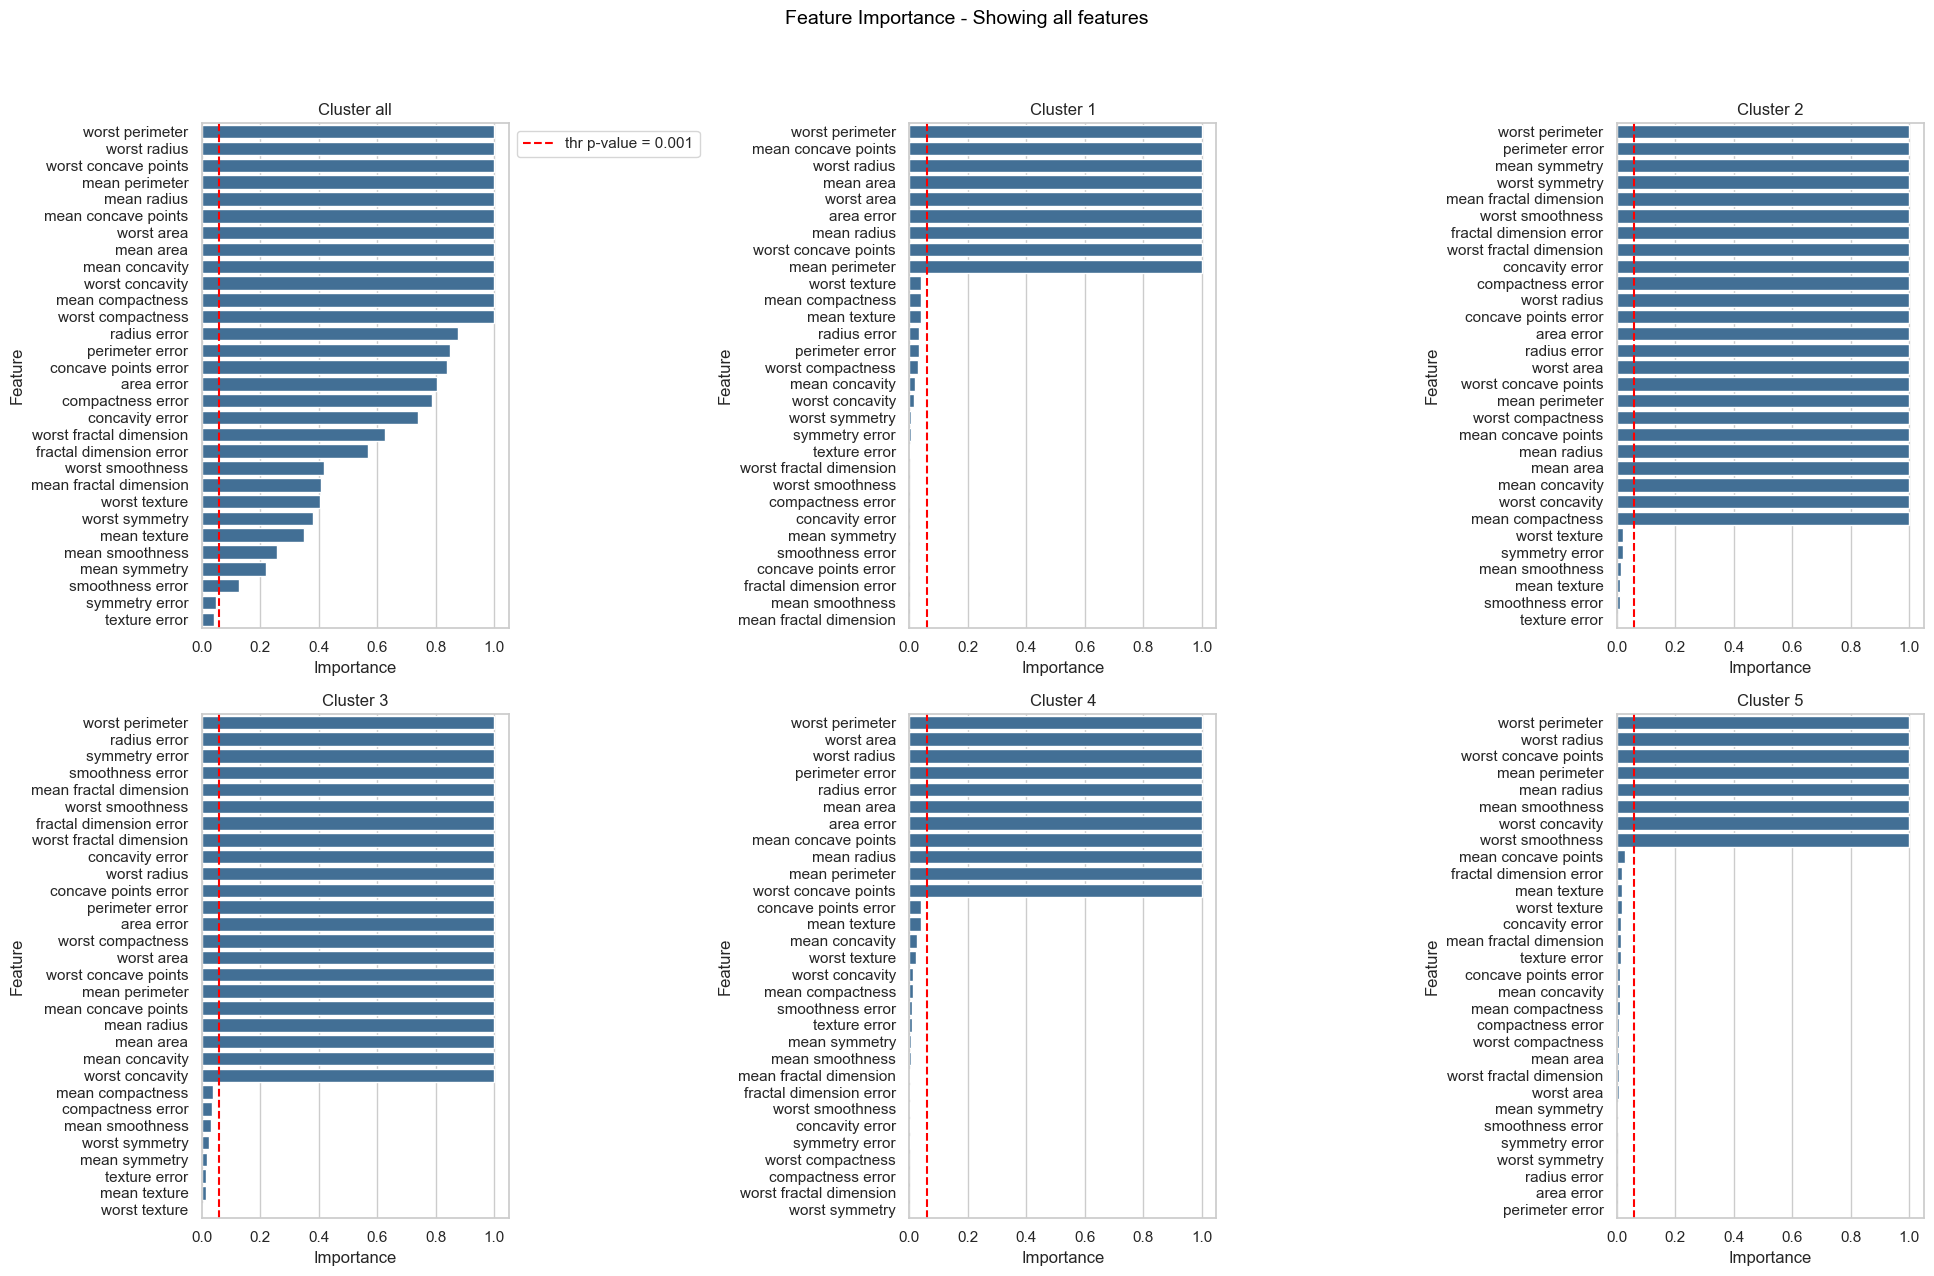

In [9]:
%matplotlib inline
# Plot global and local feature importance
fgc.plot_feature_importance(thr_pvalue=0.001, num_cols=3)

The plots above indicate that while all features help to distinguish the different clusters, not all features are important for each cluster. For cluster 4, for instance, only a few features show a  different distribution from the background distribution.

### Visualizing the decision paths of the Random Forest model

Forest-Guided Clustering provides the special option to visualize the decision path of a Random Forest model, reflecting the decision-making process of that model, in a heatmap summary plot and a feature-wise distribution plot. The heatmap provides a general overview of the target value attribution and feature enrichment / depletion per cluster.  We can see which classes or target values fall into which cluster, and samples that fall into the "wrong" cluster can be inspected further as they might be extreme outliers or wrongly labeled samples / measurement errors. The distribution plots contain the same information as the heatmap but are presented in a different way. They help us understand the distribution of feature values within each cluster, e.g., having a small or high within-cluster-variation. 

We can choose which features we want to plot by specifying the p-value threshold applied to the p-values of the features from the global feature importance calculation. By selecting a lower p-value threshold, we only plot features that show high differences between cluster-wise feature distributions. 

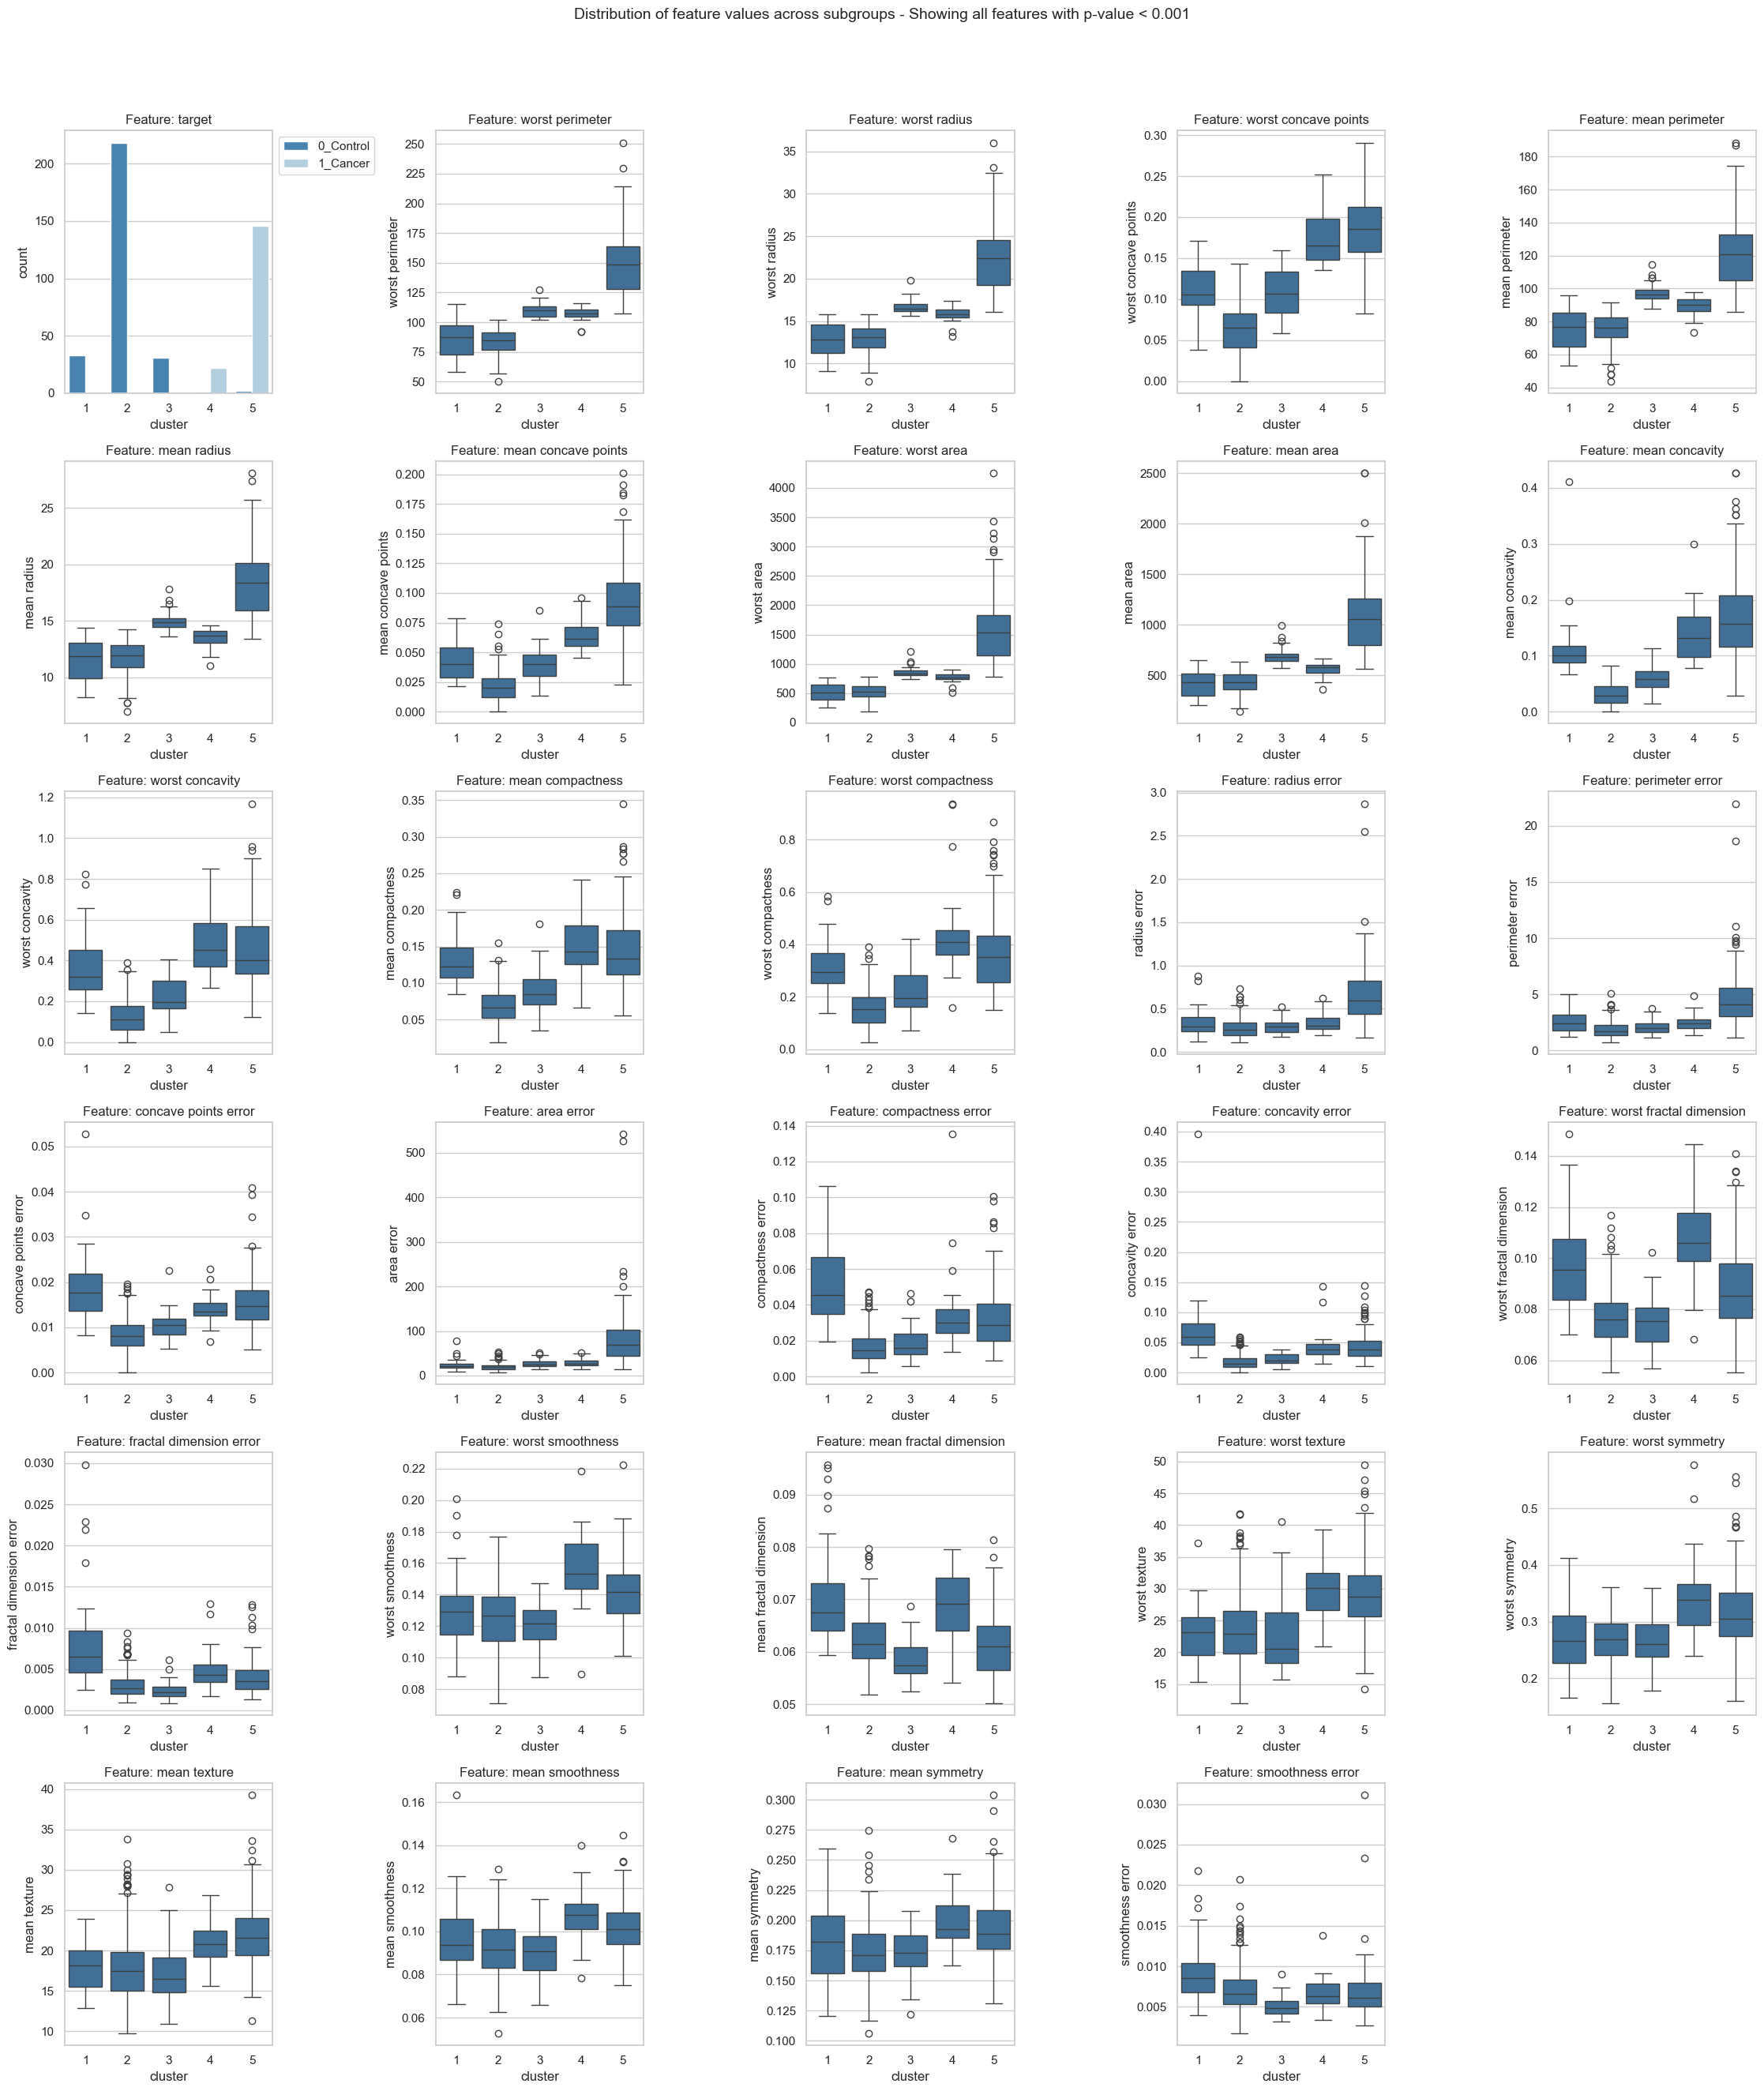

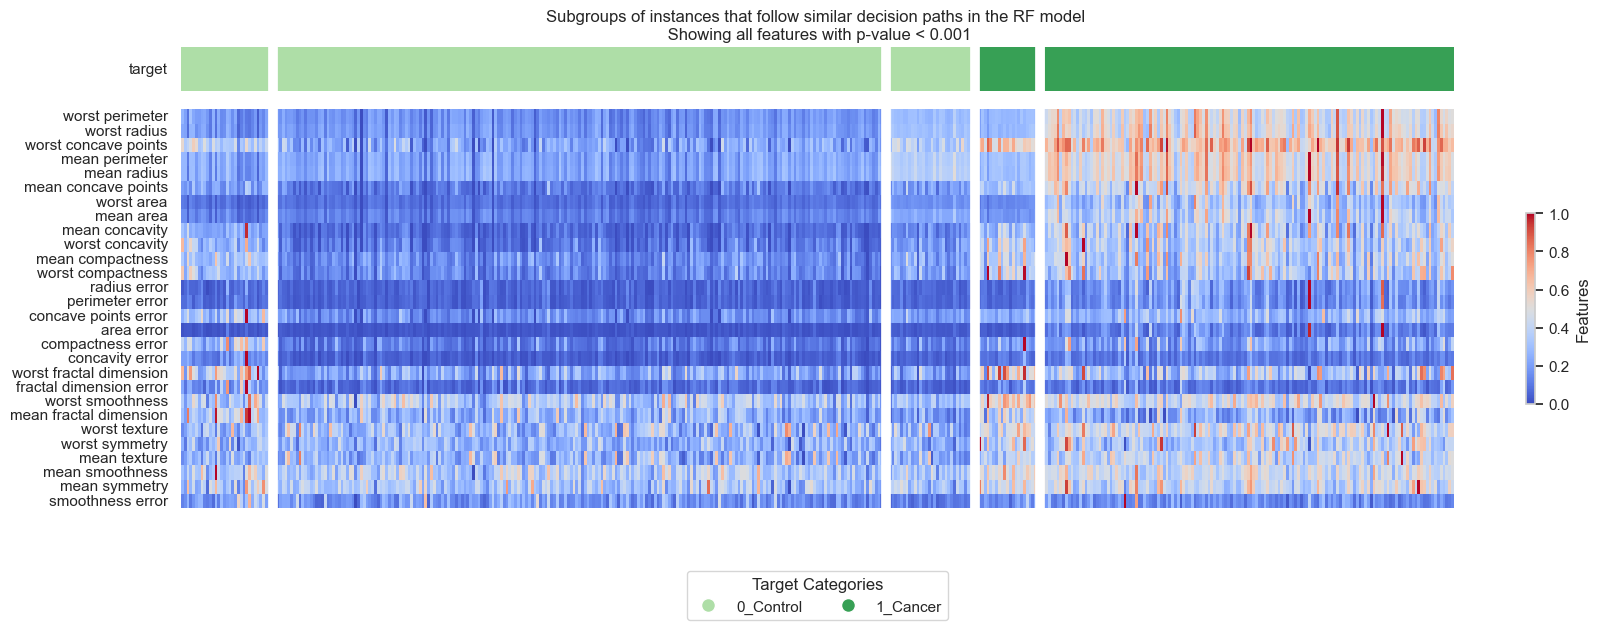

In [10]:
fgc.plot_decision_paths(thr_pvalue=0.001, num_cols=5) # feel free to try different p-values thresholds

<font color='green'>

#### Question 3: The feature AveRooms has a high feature importance, how is its distribution across clusters?

<font color='grey'>

#### Your Answer: 
Features with significantly different value distributions across clusters have a high feature importance.

<font color='green'>

#### Question 4: Which conclusions can we draw from the decision path plots above?

<font color='grey'>

#### Your Answer: 
The decision path plots indicate that we have two very similar clusters of control patients (cluster 1 and 2), which mainly differ in the concavity and compactness features. The third cluster of control patients maily differ in the radius and perimeter features from the other two control clusters. Considering the cancer patients, we observe two cluster, where the first (cluster 4) seems to be very similar to the third control group cluster, where the main difference can be observed in the concavity features. The second cluster of cancer patients (cluster 5), which contains the majority of cancer patients shows higher values in almost all important features compared to the other four clusters. 